### Importing Necessary Libraries

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
# from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [2]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [3]:
labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15995,15995,./Data/train/train/15995.tif,2
15996,15996,./Data/train/train/15996.tif,15
15997,15997,./Data/train/train/15997.tif,3
15998,15998,./Data/train/train/15998.tif,9


In [4]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [5]:
train_labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15195,15995,./Data/train/train/15995.tif,2
15196,15996,./Data/train/train/15996.tif,15
15197,15997,./Data/train/train/15997.tif,3
15198,15998,./Data/train/train/15998.tif,9


In [6]:
test_labels

,id,images,label
0,18,./Data/train/train/18.tif,11
1,25,./Data/train/train/25.tif,8
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
...,...,...,...
795,15816,./Data/train/train/15816.tif,2
796,15824,./Data/train/train/15824.tif,2
797,15832,./Data/train/train/15832.tif,11
798,15863,./Data/train/train/15863.tif,15


In [7]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

## Data Preparation

We have already generated the Extracted Feature Vectors from the ResNet Model now we train using that, so we load those feature vectors.

In [8]:
FEATURE_DIM = 1536

In [9]:
# fine_tune_data = np.concatenate([np.transpose(np.load(f'./Data/Inception-ResNet-4P-train-precompute/train_data_precomp-{idx}.npy'), (1,0,2)) for idx in range(10)])
# np.save(f'./Data/Inception-ResNet-4P-train-precompute/whole_train_data_precomp.npy', fine_tune_data)
# fine_tune_data.shape

In [10]:
fine_tune_data = np.load('./Data/Inception-ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data.shape

(16000, 5, 1536)

In [11]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [12]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 5, 1536)

In [13]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [14]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 5, 1536)

In [15]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

## Fine-Tuning Models

The fine-tuning part of our model.

In [16]:
def ftmodel():
    inputs = Input(shape=(5, FEATURE_DIM))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.5
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_3')(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='Inception-RestNet-FineTune')
    return model1

In [17]:
model1 = ftmodel()
model1.summary()

Metal device set to: Apple M1 Max
Model: "Inception-RestNet-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 1536)]         0         
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 batch_normalization (BatchN  (None, 7680)             30720     
 ormalization)                                                   
                                                                 
 top_dropout_2 (Dropout)     (None, 7680)              0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               3932672   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNorm

2022-10-09 17:06:16.495787: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-09 17:06:16.495930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Model Training

The fine-tuning will be done on the ResNet's $2048D$ representation vectors.

In [18]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [19]:
EPOCHS = 1000
checkpoint_filepaths = ['./Models/Inception-ResNet-4P/auto-Inception-ResNet-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [20]:
history = model1.fit(fine_tune_data_train, fine_tune_labels_train, epochs=EPOCHS, batch_size=800, validation_data=(fine_tune_data_test, fine_tune_labels_test), validation_batch_size=800, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/Inception-ResNet-4P/effnet-4p-model-weights")
model1.load_weights('./Models/Inception-ResNet-4P/effnet-4p-model-weights')

2022-10-09 17:06:16.694459: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/1000


2022-10-09 17:06:16.992509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 2.3646 - accuracy: 0.4230

2022-10-09 17:06:17.783614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 1s 39ms/step - loss: 2.3646 - accuracy: 0.4230 - val_loss: 2.1632 - val_accuracy: 0.3000
Epoch 2/1000
19/19 [==============================] - 0s 23ms/step - loss: 1.6566 - accuracy: 0.5554 - val_loss: 1.9514 - val_accuracy: 0.4375
Epoch 3/1000
19/19 [==============================] - 0s 23ms/step - loss: 1.4503 - accuracy: 0.5941 - val_loss: 1.8666 - val_accuracy: 0.5000
Epoch 4/1000
19/19 [==============================] - 0s 23ms/step - loss: 1.3263 - accuracy: 0.6235 - val_loss: 1.7817 - val_accuracy: 0.5275
Epoch 5/1000
19/19 [==============================] - 0s 23ms/step - loss: 1.2350 - accuracy: 0.6515 - val_loss: 1.7167 - val_accuracy: 0.5625
Epoch 6/1000
19/19 [==============================] - 0s 23ms/step - loss: 1.1624 - accuracy: 0.6694 - val_loss: 1.6396 - val_accuracy: 0.5813
Epoch 7/1000
19/19 [==============================] - 0s 22ms/step - loss: 1.1117 - accuracy: 0.6797 - val_loss: 1.5484 - val_accuracy: 0.6187
Epoch 8/1000

19/19 [==============================] - 0s 14ms/step - loss: 0.3865 - accuracy: 0.8974 - val_loss: 0.8684 - val_accuracy: 0.7612
Epoch 59/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.3687 - accuracy: 0.9005 - val_loss: 0.8703 - val_accuracy: 0.7688
Epoch 60/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.3691 - accuracy: 0.9018 - val_loss: 0.8667 - val_accuracy: 0.7788
Epoch 61/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.3676 - accuracy: 0.9022 - val_loss: 0.8912 - val_accuracy: 0.7637
Epoch 62/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.3618 - accuracy: 0.9020 - val_loss: 0.8867 - val_accuracy: 0.7688
Epoch 63/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.3552 - accuracy: 0.9076 - val_loss: 0.8844 - val_accuracy: 0.7675
Epoch 64/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.3511 - accuracy: 0.9055 - val_loss: 0.8758 - val_accuracy: 0.7662
Epoch 

Epoch 115/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.2123 - accuracy: 0.9561 - val_loss: 0.9701 - val_accuracy: 0.7688
Epoch 116/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.2111 - accuracy: 0.9557 - val_loss: 0.9625 - val_accuracy: 0.7763
Epoch 117/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.2127 - accuracy: 0.9536 - val_loss: 0.9687 - val_accuracy: 0.7763
Epoch 118/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.2060 - accuracy: 0.9567 - val_loss: 0.9640 - val_accuracy: 0.7662
Epoch 119/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.2049 - accuracy: 0.9574 - val_loss: 0.9791 - val_accuracy: 0.7688
Epoch 120/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.2035 - accuracy: 0.9583 - val_loss: 0.9904 - val_accuracy: 0.7725
Epoch 121/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.1996 - accuracy: 0.9608 - val_loss: 0.9790 - val_ac

19/19 [==============================] - 0s 22ms/step - loss: 0.1578 - accuracy: 0.9732 - val_loss: 1.0793 - val_accuracy: 0.7775
Epoch 172/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1706 - accuracy: 0.9683 - val_loss: 1.0586 - val_accuracy: 0.7725
Epoch 173/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1626 - accuracy: 0.9738 - val_loss: 1.0871 - val_accuracy: 0.7738
Epoch 174/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.1609 - accuracy: 0.9729 - val_loss: 1.0821 - val_accuracy: 0.7763
Epoch 175/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.1647 - accuracy: 0.9713 - val_loss: 1.0450 - val_accuracy: 0.7725
Epoch 176/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1607 - accuracy: 0.9721 - val_loss: 1.0546 - val_accuracy: 0.7650
Epoch 177/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1587 - accuracy: 0.9728 - val_loss: 1.0424 - val_accuracy: 0.7862


19/19 [==============================] - 0s 17ms/step - loss: 0.1484 - accuracy: 0.9782 - val_loss: 1.1611 - val_accuracy: 0.7625
Epoch 228/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1476 - accuracy: 0.9787 - val_loss: 1.1459 - val_accuracy: 0.7725
Epoch 229/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1456 - accuracy: 0.9793 - val_loss: 1.1351 - val_accuracy: 0.7713
Epoch 230/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1421 - accuracy: 0.9809 - val_loss: 1.1378 - val_accuracy: 0.7775
Epoch 231/1000
19/19 [==============================] - 0s 21ms/step - loss: 0.1415 - accuracy: 0.9806 - val_loss: 1.1203 - val_accuracy: 0.7775
Epoch 232/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1421 - accuracy: 0.9805 - val_loss: 1.1152 - val_accuracy: 0.7837
Epoch 233/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1432 - accuracy: 0.9810 - val_loss: 1.1166 - val_accuracy: 0.7825


19/19 [==============================] - 0s 14ms/step - loss: 0.1397 - accuracy: 0.9821 - val_loss: 1.2238 - val_accuracy: 0.7662
Epoch 284/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1412 - accuracy: 0.9809 - val_loss: 1.2296 - val_accuracy: 0.7700
Epoch 285/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.1365 - accuracy: 0.9822 - val_loss: 1.2068 - val_accuracy: 0.7688
Epoch 286/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1385 - accuracy: 0.9820 - val_loss: 1.2028 - val_accuracy: 0.7738
Epoch 287/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.1399 - accuracy: 0.9798 - val_loss: 1.1967 - val_accuracy: 0.7763
Epoch 288/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1392 - accuracy: 0.9815 - val_loss: 1.1817 - val_accuracy: 0.7763
Epoch 289/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1373 - accuracy: 0.9824 - val_loss: 1.1881 - val_accuracy: 0.7600


19/19 [==============================] - 0s 15ms/step - loss: 0.1402 - accuracy: 0.9826 - val_loss: 1.2122 - val_accuracy: 0.7688
Epoch 340/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.1387 - accuracy: 0.9830 - val_loss: 1.2032 - val_accuracy: 0.7775
Epoch 341/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1395 - accuracy: 0.9840 - val_loss: 1.2114 - val_accuracy: 0.7763
Epoch 342/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.1340 - accuracy: 0.9840 - val_loss: 1.1665 - val_accuracy: 0.7763
Epoch 343/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1357 - accuracy: 0.9834 - val_loss: 1.1990 - val_accuracy: 0.7700
Epoch 344/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1366 - accuracy: 0.9842 - val_loss: 1.1902 - val_accuracy: 0.7700
Epoch 345/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1355 - accuracy: 0.9848 - val_loss: 1.2342 - val_accuracy: 0.7637


19/19 [==============================] - 0s 14ms/step - loss: 0.1400 - accuracy: 0.9843 - val_loss: 1.2886 - val_accuracy: 0.7637
Epoch 396/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1368 - accuracy: 0.9839 - val_loss: 1.2848 - val_accuracy: 0.7713
Epoch 397/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1368 - accuracy: 0.9840 - val_loss: 1.2479 - val_accuracy: 0.7688
Epoch 398/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1330 - accuracy: 0.9861 - val_loss: 1.2902 - val_accuracy: 0.7750
Epoch 399/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1360 - accuracy: 0.9846 - val_loss: 1.2821 - val_accuracy: 0.7725
Epoch 400/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1367 - accuracy: 0.9851 - val_loss: 1.2698 - val_accuracy: 0.7675
Epoch 401/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1340 - accuracy: 0.9862 - val_loss: 1.2258 - val_accuracy: 0.7713


19/19 [==============================] - 0s 14ms/step - loss: 0.1362 - accuracy: 0.9859 - val_loss: 1.3420 - val_accuracy: 0.7600
Epoch 452/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1340 - accuracy: 0.9858 - val_loss: 1.3490 - val_accuracy: 0.7750
Epoch 453/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1374 - accuracy: 0.9847 - val_loss: 1.2874 - val_accuracy: 0.7825
Epoch 454/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1341 - accuracy: 0.9866 - val_loss: 1.2752 - val_accuracy: 0.7675
Epoch 455/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1340 - accuracy: 0.9864 - val_loss: 1.3041 - val_accuracy: 0.7713
Epoch 456/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1325 - accuracy: 0.9865 - val_loss: 1.2836 - val_accuracy: 0.7812
Epoch 457/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1343 - accuracy: 0.9856 - val_loss: 1.2503 - val_accuracy: 0.7775


19/19 [==============================] - 0s 14ms/step - loss: 0.1318 - accuracy: 0.9855 - val_loss: 1.3323 - val_accuracy: 0.7713
Epoch 508/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1307 - accuracy: 0.9882 - val_loss: 1.3391 - val_accuracy: 0.7750
Epoch 509/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1318 - accuracy: 0.9878 - val_loss: 1.2987 - val_accuracy: 0.7800
Epoch 510/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1287 - accuracy: 0.9886 - val_loss: 1.3053 - val_accuracy: 0.7688
Epoch 511/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1339 - accuracy: 0.9862 - val_loss: 1.3159 - val_accuracy: 0.7775
Epoch 512/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1366 - accuracy: 0.9863 - val_loss: 1.3014 - val_accuracy: 0.7763
Epoch 513/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1344 - accuracy: 0.9861 - val_loss: 1.2956 - val_accuracy: 0.7837


19/19 [==============================] - 0s 14ms/step - loss: 0.1344 - accuracy: 0.9878 - val_loss: 1.3042 - val_accuracy: 0.7837
Epoch 564/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1301 - accuracy: 0.9896 - val_loss: 1.2785 - val_accuracy: 0.7800
Epoch 565/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1324 - accuracy: 0.9876 - val_loss: 1.2804 - val_accuracy: 0.7900
Epoch 566/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1288 - accuracy: 0.9889 - val_loss: 1.3236 - val_accuracy: 0.7688
Epoch 567/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1350 - accuracy: 0.9866 - val_loss: 1.3414 - val_accuracy: 0.7763
Epoch 568/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1327 - accuracy: 0.9874 - val_loss: 1.3000 - val_accuracy: 0.7775
Epoch 569/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.1286 - accuracy: 0.9889 - val_loss: 1.3408 - val_accuracy: 0.7825


19/19 [==============================] - 0s 15ms/step - loss: 0.1282 - accuracy: 0.9889 - val_loss: 1.3266 - val_accuracy: 0.7862
Epoch 620/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1303 - accuracy: 0.9889 - val_loss: 1.3398 - val_accuracy: 0.7887
Epoch 621/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.1332 - accuracy: 0.9874 - val_loss: 1.3853 - val_accuracy: 0.7788
Epoch 622/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1308 - accuracy: 0.9876 - val_loss: 1.3216 - val_accuracy: 0.7837
Epoch 623/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.1311 - accuracy: 0.9881 - val_loss: 1.3290 - val_accuracy: 0.7825
Epoch 624/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.1273 - accuracy: 0.9899 - val_loss: 1.2827 - val_accuracy: 0.7800
Epoch 625/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.1311 - accuracy: 0.9876 - val_loss: 1.2752 - val_accuracy: 0.7825


19/19 [==============================] - 0s 13ms/step - loss: 0.1302 - accuracy: 0.9885 - val_loss: 1.3524 - val_accuracy: 0.7837
Epoch 676/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1327 - accuracy: 0.9874 - val_loss: 1.3098 - val_accuracy: 0.7887
Epoch 677/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1364 - accuracy: 0.9870 - val_loss: 1.3619 - val_accuracy: 0.7825
Epoch 678/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1387 - accuracy: 0.9859 - val_loss: 1.3873 - val_accuracy: 0.7875
Epoch 679/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1340 - accuracy: 0.9873 - val_loss: 1.3688 - val_accuracy: 0.7763
Epoch 680/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1370 - accuracy: 0.9876 - val_loss: 1.3501 - val_accuracy: 0.7837
Epoch 681/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1314 - accuracy: 0.9880 - val_loss: 1.3750 - val_accuracy: 0.7925


19/19 [==============================] - 0s 13ms/step - loss: 0.1312 - accuracy: 0.9883 - val_loss: 1.3532 - val_accuracy: 0.7875
Epoch 732/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1305 - accuracy: 0.9896 - val_loss: 1.3408 - val_accuracy: 0.7788
Epoch 733/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1308 - accuracy: 0.9875 - val_loss: 1.3340 - val_accuracy: 0.7788
Epoch 734/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1286 - accuracy: 0.9901 - val_loss: 1.3403 - val_accuracy: 0.7812
Epoch 735/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1276 - accuracy: 0.9905 - val_loss: 1.3563 - val_accuracy: 0.7788
Epoch 736/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1309 - accuracy: 0.9888 - val_loss: 1.3311 - val_accuracy: 0.7850
Epoch 737/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1334 - accuracy: 0.9880 - val_loss: 1.3201 - val_accuracy: 0.7950


19/19 [==============================] - 0s 13ms/step - loss: 0.1307 - accuracy: 0.9882 - val_loss: 1.3357 - val_accuracy: 0.7788
Epoch 788/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1276 - accuracy: 0.9897 - val_loss: 1.3371 - val_accuracy: 0.7662
Epoch 789/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1336 - accuracy: 0.9879 - val_loss: 1.3337 - val_accuracy: 0.7775
Epoch 790/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1320 - accuracy: 0.9884 - val_loss: 1.3538 - val_accuracy: 0.7725
Epoch 791/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1308 - accuracy: 0.9888 - val_loss: 1.3688 - val_accuracy: 0.7775
Epoch 792/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1325 - accuracy: 0.9877 - val_loss: 1.3350 - val_accuracy: 0.7725
Epoch 793/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1296 - accuracy: 0.9891 - val_loss: 1.3432 - val_accuracy: 0.7675


19/19 [==============================] - 0s 12ms/step - loss: 0.1311 - accuracy: 0.9884 - val_loss: 1.3548 - val_accuracy: 0.7750
Epoch 844/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1375 - accuracy: 0.9868 - val_loss: 1.3019 - val_accuracy: 0.7825
Epoch 845/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1315 - accuracy: 0.9888 - val_loss: 1.3458 - val_accuracy: 0.7763
Epoch 846/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1342 - accuracy: 0.9886 - val_loss: 1.3763 - val_accuracy: 0.7738
Epoch 847/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1351 - accuracy: 0.9882 - val_loss: 1.3506 - val_accuracy: 0.7700
Epoch 848/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1347 - accuracy: 0.9876 - val_loss: 1.3436 - val_accuracy: 0.7775
Epoch 849/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1284 - accuracy: 0.9897 - val_loss: 1.3346 - val_accuracy: 0.7725


19/19 [==============================] - 0s 13ms/step - loss: 0.1339 - accuracy: 0.9880 - val_loss: 1.3648 - val_accuracy: 0.7825
Epoch 900/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1298 - accuracy: 0.9890 - val_loss: 1.3909 - val_accuracy: 0.7788
Epoch 901/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1303 - accuracy: 0.9887 - val_loss: 1.4471 - val_accuracy: 0.7775
Epoch 902/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1337 - accuracy: 0.9872 - val_loss: 1.3857 - val_accuracy: 0.7788
Epoch 903/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1285 - accuracy: 0.9901 - val_loss: 1.4240 - val_accuracy: 0.7700
Epoch 904/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1320 - accuracy: 0.9885 - val_loss: 1.3462 - val_accuracy: 0.7763
Epoch 905/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1313 - accuracy: 0.9891 - val_loss: 1.3632 - val_accuracy: 0.7700


19/19 [==============================] - 0s 12ms/step - loss: 0.1323 - accuracy: 0.9880 - val_loss: 1.4108 - val_accuracy: 0.7812
Epoch 956/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1325 - accuracy: 0.9881 - val_loss: 1.3980 - val_accuracy: 0.7763
Epoch 957/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1334 - accuracy: 0.9881 - val_loss: 1.4122 - val_accuracy: 0.7750
Epoch 958/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1346 - accuracy: 0.9878 - val_loss: 1.3873 - val_accuracy: 0.7713
Epoch 959/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1306 - accuracy: 0.9884 - val_loss: 1.4217 - val_accuracy: 0.7738
Epoch 960/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1300 - accuracy: 0.9899 - val_loss: 1.3996 - val_accuracy: 0.7788
Epoch 961/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1331 - accuracy: 0.9874 - val_loss: 1.3959 - val_accuracy: 0.7688


In [21]:
model1.load_weights('./Models/Inception-ResNet-4P/auto-Inception-ResNet-FT-model-weight')

In [22]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

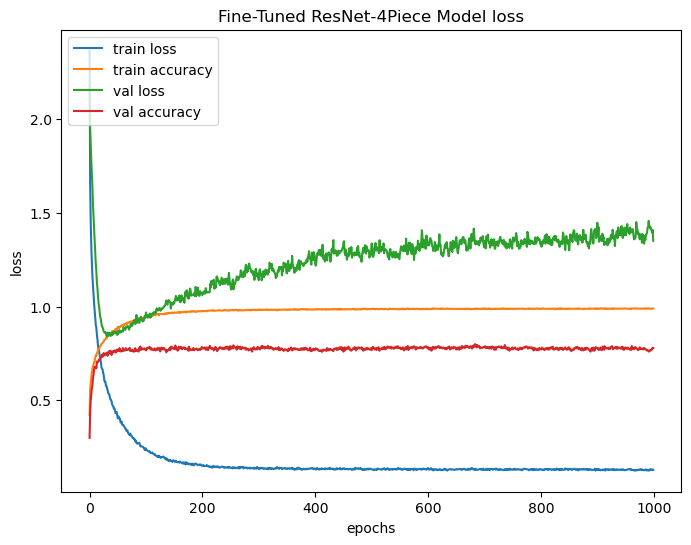

In [23]:
plot_train_loss(history, 'Fine-Tuned ResNet-4Piece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [24]:
train_preds = model1.predict(fine_tune_data_train)

 71/475 [===>..........................] - ETA: 0s

2022-10-09 17:10:54.061183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 1s 3ms/step


In [25]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [26]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [27]:
np.sum(train_pred_labels == train_labels['label'])

15197

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [28]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
3597,3781,./Data/train/train/3781.tif,0
9198,9682,./Data/train/train/9682.tif,12
12255,12896,./Data/train/train/12896.tif,9


In [29]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,1.000000,0.998978,0.999488,978
1,1.000000,1.000000,1.000000,925
2,1.000000,1.000000,1.000000,925
3,1.000000,1.000000,1.000000,947
4,0.998926,1.000000,0.999463,930
5,1.000000,1.000000,1.000000,962
6,1.000000,1.000000,1.000000,998
7,0.997814,1.000000,0.998906,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.998951,0.999475,953


#### On Train-Test Data

In [30]:
test_preds = model1.predict(fine_tune_data_test)

25/25 [==============================] - 0s 2ms/step


In [31]:
test_pred_labels = np.argmax(test_preds, axis=-1)

In [32]:
test_pred_labels

array([11,  8,  6,  7,  1,  6, 13, 12, 14,  1,  6, 15,  7, 14, 13, 11,  0,
        9,  9, 12, 12, 14,  3, 12,  6,  0,  3,  8,  3,  3, 15,  1,  9,  2,
        7,  8,  4, 14, 11,  9,  6, 12, 14,  2,  5, 14,  5, 15, 13,  4,  0,
       10,  5, 12, 11, 14, 15,  9,  9,  2, 15,  6, 11, 11,  8, 11,  8,  0,
        6,  3,  4,  4, 12,  5,  8,  6,  7,  0, 12, 11, 11, 15, 12, 12,  9,
        8, 13, 13, 13, 13, 10, 11,  4, 10,  1,  7, 11,  8, 13, 10,  3, 10,
        5,  9, 10, 14,  8,  2,  5, 12,  7,  5,  9,  4, 12,  9, 12, 13, 11,
        6, 13,  1,  0, 12,  1,  5, 13, 12, 15, 11,  3, 11,  6,  1,  6,  9,
       14, 10,  7, 14, 10,  8, 11, 12,  8, 10,  8,  9,  2, 13,  0,  5,  4,
       14,  4,  9,  4, 14,  7,  7,  8,  4,  4, 12,  5,  8, 15,  3,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 11, 13, 11,  6, 13,  4,
       14, 11,  7, 15,  0,  3,  0, 10, 13, 13, 10, 11, 11, 11,  1,  9,  1,
        9,  0, 13, 12, 12,  1,  4,  8,  7,  6, 13,  5,  4, 12,  8,  0,  9,
       13, 15,  0,  7,  5

In [33]:
np.sum(test_pred_labels == test_labels['label'])

628

In [34]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
5,67,./Data/train/train/67.tif,9
7,100,./Data/train/train/100.tif,10
14,203,./Data/train/train/203.tif,1
...,...,...,...
779,15568,./Data/train/train/15568.tif,9
782,15582,./Data/train/train/15582.tif,3
785,15621,./Data/train/train/15621.tif,15
788,15687,./Data/train/train/15687.tif,12


In [35]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.660714,0.685185,0.672727,54
1,0.642857,0.613636,0.627907,44
2,0.928571,0.906977,0.917647,43
3,0.872340,0.891304,0.881720,46
4,0.829268,0.944444,0.883117,36
5,0.653061,0.640000,0.646465,50
6,0.860465,0.804348,0.831461,46
7,0.857143,0.807692,0.831683,52
8,0.843750,1.000000,0.915254,54
9,0.883721,0.808511,0.844444,47


In [36]:
np.mean(fscore)

0.7859638237161761

#### On Validation Data

Generating Predictions for the Validation Set

In [37]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [38]:
fine_tune_data_validation = np.load('./Data/Inception-ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation.shape

(900, 5, 1536)

In [39]:
valid_preds = model1.predict(fine_tune_data_validation)

29/29 [==============================] - 0s 3ms/step


2022-10-09 17:10:55.669809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [40]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

### Submission

For Kaggle Submission

In [41]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,4
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,7
896,18697,12
897,18698,8
898,18699,3


In [42]:
submission_data.to_csv('./Submissions/submission-inception-resnet-4p.csv', index=False)